In [3]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import sys
sys.path.append('/home/ubuntu/TSADModelSelection/') # TODO: Make this relative path maybe
sys.path.append('/home/ubuntu/PyMAD/') # TODO: Make this relative path maybe

from src.pymad.logger import Logger
from model_selector import utils
from model_selector.metrics import compute_correlation
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ENTITIES = ['machine-1-1','machine-1-2','machine-1-3','machine-1-4','machine-1-5','machine-1-6','machine-1-7','machine-1-8',
            'machine-2-1', 'machine-2-2','machine-2-3','machine-2-4','machine-2-5','machine-2-6','machine-2-7','machine-2-8',
            'machine-2-9', 'machine-3-1', 'machine-3-2', 'machine-3-3', 'machine-3-4','machine-3-5','machine-3-6','machine-3-7',
            'machine-3-8', 'machine-3-9','machine-3-10', 'machine-3-11']

MODEL_ARCHITECTURES = ['dghl', 'mean_deviation']
PATH_TO_METRICS = r'/home/ubuntu/TSADModelSelection/observed_metrics/collected_metrics/metrics_dictionary.meta'
metrics_name = utils.load_metrics(PATH_TO_METRICS)['Metrics']

## Correlations of Unsupervised Metrics with PR-AUC

In [3]:
corr_by_metric_spearman = {}
corr_by_metric_kendall = {}
N_METRICS = len(metrics_name)-2
for i in range(1, N_METRICS+1):
    corr_by_metric_spearman[metrics_name[i]] = []
    corr_by_metric_kendall[metrics_name[i]] = []
for entity_name in ENTITIES:
    for model_name in MODEL_ARCHITECTURES:
        metrics_matrix = utils.get_unsupervsed_performance_metrics(entity_name=entity_name, model_name=model_name)
        corr_result = compute_correlation(metrics_array=metrics_matrix, return_p_val=True, metrics_name=metrics_name)
        for i in range(1, len(metrics_name)-1):
            corr_by_metric_spearman[metrics_name[i]].append(corr_result[metrics_name[i]]["Spearman's Corr"])
            corr_by_metric_kendall[metrics_name[i]].append(corr_result[metrics_name[i]]["Kendall's Tau Corr"])

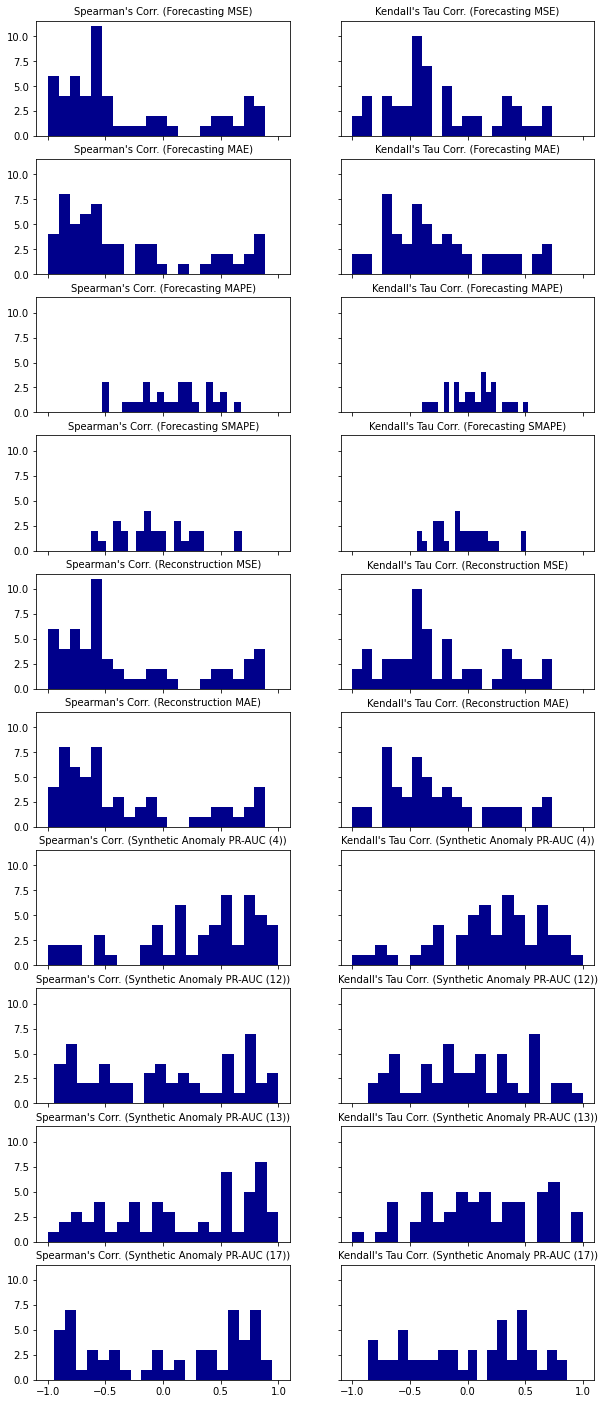

In [4]:
fig, ax = plt.subplots(nrows=N_METRICS, ncols=2, figsize=(10, 25), sharex=True, sharey=True)
plt.title(label='Correlation of Metrics with True PR-AUC in the SMD dataset')
for i, metric in enumerate(corr_by_metric_spearman.keys()):
    ax[i, 0].hist(corr_by_metric_spearman[metric], bins=20, color='darkblue')
    ax[i, 0].set_title(f"Spearman's Corr. ({metric})", fontsize=10)
    ax[i, 1].hist(corr_by_metric_kendall[metric], bins=20, color='darkblue')
    ax[i, 1].set_title(f"Kendall's Tau Corr. ({metric})", fontsize=10)
plt.savefig('../figures/metric_corr_with_true_prauc_smd.png')
plt.show()

## Model Selection

In [5]:
perf_metric = []
corr_metric = []
for entity in ENTITIES:            
    PATH = f'/home/ubuntu/TSADModelSelection/results/kemeny_young_aggregation_ms/{entity}.data'
    with open(PATH, 'rb') as f: 
        eval_dict = pkl.load(f)
    # print(f"Regret over Max PR-AUC: {eval_dict['Evaluation metrics']['Regret over Max PR-AUC']}")
    # pprint.pprint(eval_dict['Evaluation metrics']['Regret over Max PR-AUC'])
    perf_metric.append(eval_dict['Evaluation metrics']['Gain over Mean PR-AUC'])
    metrics_matrix = utils.get_unsupervsed_performance_metrics(entity_name=entity, model_name='all')
    corr_result = compute_correlation(metrics_array=metrics_matrix, return_p_val=False, metrics_name=metrics_name)
    # pprint.pprint(corr_result['Forecasting MSE']["Kendall's Tau Corr"])
    corr_metric.append(corr_result['Forecasting MSE']["Kendall's Tau Corr"])
    

### Plot of Correlation of Forecasting Error versus Percentage Loss over Max PR-AUC

Median Percentage Loss over Max PR-AUC: 0.07454392701035847
IQR Percentage Loss over Max PR-AUC: 0.25250271350656867


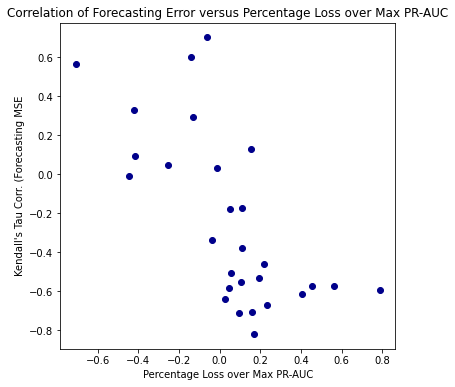

In [6]:
# print(f'Average Percentage Loss over Max PR-AUC: {np.mean(perf_metric)}')
print(f'Median Percentage Loss over Max PR-AUC: {np.median(perf_metric)}')
print(f'IQR Percentage Loss over Max PR-AUC: {np.quantile(perf_metric, 0.75) - np.quantile(perf_metric, 0.25)}')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
# plt.title(label='Correlation of Forecasting Error versus Percentage Loss over Max PR-AUC')
plt.title(label='Correlation of Forecasting Error versus Gain over Mean PR-AUC')
ax.scatter(x=perf_metric, y=corr_metric, color='darkblue')
# ax.set_xlabel('Percentage Loss over Max PR-AUC')
ax.set_xlabel('Gain over Mean PR-AUC')
ax.set_ylabel("Kendall's Tau Corr. (Forecasting MSE")
plt.savefig('../figures/metric_corr_with_ranking_perf_smd.png')
plt.show()


## Hyper-parameter Tuning

In [7]:
perf_metric = []
corr_metric = []
for entity in ENTITIES:            
    PATH = f'/home/ubuntu/TSADModelSelection/results/kemeny_young_aggregation_dghl_hpt/{entity}.data'
    with open(PATH, 'rb') as f: 
        eval_dict = pkl.load(f)
    # print(f"Regret over Max PR-AUC: {eval_dict['Evaluation metrics']['Regret over Max PR-AUC']}")
    # pprint.pprint(eval_dict['Evaluation metrics']['Regret over Max PR-AUC'])
    perf_metric.append(eval_dict['Evaluation metrics']['Percentage Loss over Max PR-AUC'])
    metrics_matrix = utils.get_unsupervsed_performance_metrics(entity_name=entity, model_name='all')
    corr_result = compute_correlation(metrics_array=metrics_matrix, return_p_val=False, metrics_name=metrics_name)
    # pprint.pprint(corr_result['Forecasting MSE']["Kendall's Tau Corr"])
    corr_metric.append(corr_result['Forecasting MSE']["Kendall's Tau Corr"])
    

Median Percentage Loss over Max PR-AUC: 0.0630010500870673
IQR Percentage Loss over Max PR-AUC: 0.33273350077261726


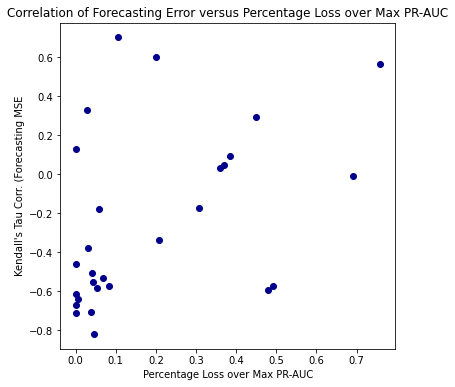

In [8]:
# print(f'Average Percentage Loss over Max PR-AUC: {np.mean(perf_metric)}')
print(f'Median Percentage Loss over Max PR-AUC: {np.median(perf_metric)}')
print(f'IQR Percentage Loss over Max PR-AUC: {np.quantile(perf_metric, 0.75) - np.quantile(perf_metric, 0.25)}')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
plt.title(label='Correlation of Forecasting Error versus Percentage Loss over Max PR-AUC')
ax.scatter(x=perf_metric, y=corr_metric, color='darkblue')
ax.set_xlabel('Percentage Loss over Max PR-AUC')
ax.set_ylabel("Kendall's Tau Corr. (Forecasting MSE")
plt.savefig('../figures/metric_corr_with_ranking_perf_hpt_smd.png')
plt.show()
